In [1]:
import os
from dotenv import load_dotenv
from typing import Literal, List, Dict, TypedDict
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langsmith import traceable
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [2]:
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

llm = ChatGroq(model="qwen-2.5-32b")

In [3]:
# Graph state
class State(TypedDict):
    blog: str
    topic: str
    feedback: str
    good_or_revise: str


class Feedback(BaseModel):
    grade: Literal["good", "needs revision"] = Field(
        description="Decide if the blog is entertaining, concise with maxiumum of 400 characters, with subtitles and a conclusion or needs revision.",
    )
    feedback: str = Field(
        description="If the blog is not good, provide feedback on how to improve it.",
    )


evaluator = llm.with_structured_output(Feedback)

In [4]:
# Nodes
@traceable
def llm_call_generator(state: State):
    """LLM generates a blog"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a blog about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a blog about {state['topic']}")
    
    # Debugging print statement
    print("Generated blog content:", msg.content)  
    
    return {"blog": msg.content}  # Ensure this key is returned!


@traceable
def llm_call_evaluator(state: State):
    """LLM evaluates the blog"""
    grade = evaluator.invoke(f"Grade the blog {state['blog']}")
    return {"good_or_revise": grade.grade, "feedback": grade.feedback}


@traceable
def route_blog(state: State):
    """Route back to blog generator or end based upon feedback from evaluator"""
    if state["good_or_revise"] == "good":
        return "Accepted"
    elif state["good_or_revise"] == "needs revision":
        return "llm_call_generator"


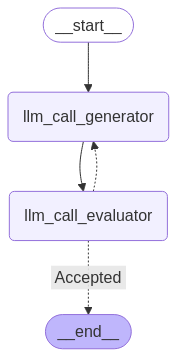

In [5]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_blog,
    {
        "Accepted": END,
        "llm_call_generator": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [6]:
# Invoke
state = optimizer_workflow.invoke({"topic": "MCP from Anthropic"})
print(state["blog"])

Generated blog content: ### Exploring MCP: Anthropic's Ambitious Step in AI Safety and Alignment

In the ever-evolving landscape of artificial intelligence (AI), the quest for safer, more aligned AI systems continues to drive innovation. One of the recent advancements in this field comes from Anthropic, a research organization working on creating AI that works as intended. Among their notable projects is Model Constituents Playground (MCP), a tool that aims to improve our understanding of AI models and how they operate.

#### What is MCP?

MCP is a web-based interface developed by Anthropic to dissect and analyze the inner workings of large language models (LLMs). It functions as a kind of playground for researchers, developers, and enthusiasts to explore the components that make up these complex systems, aiming to provide insights into why models produce certain outputs and how they can be improved.

#### The Importance of Understanding AI Models

The field of AI has seen rapid advanc